In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
from benchmarks.csketch import CSketch
import benchmarks.csolver as csolver
import matplotlib.pyplot as plt

In [18]:
rdf = pd.read_csv("results.csv")

In [32]:
rdf

,p,p_q,q_delta,q_est,q_true
0,0.001,0.000046,0.000954,31.374738,36.0
1,0.010,0.000046,0.009954,33.429016,37.0
2,0.100,0.231126,0.131126,37.131719,37.0
3,0.200,0.269057,0.069057,39.253629,37.0
4,0.300,0.335678,0.035678,41.145750,41.0
5,0.400,0.402092,0.002092,43.103889,43.0
6,0.500,0.502483,0.002483,45.296824,45.0
7,0.600,0.561931,0.038069,47.878328,49.0
8,0.700,0.669609,0.030391,51.018414,53.0
9,0.800,0.822782,0.022782,55.005411,55.0


In [21]:
rdf["q_delta"].mean()

0.029632183908045971

In [22]:
df = pd.read_csv("sampledata/shuttle.csv", usecols=["0"])
data = df["0"]
n = len(data)
sdata = np.sort(data)
amin = np.min(data)
amax = np.max(data)

In [23]:
s = CSketch(8)
s.train(data)
lambdas,steps = csolver.solve(s.m, 1e-10)
print(lambdas)
f = csolver.gen_pdf(lambdas)

[ 3.93401264  1.91851544  2.86310626 -2.22294908  1.29444691 -2.32281208
 -0.82717765 -1.3844928 ]


In [24]:
def convert(x, amin, amax):
    return (x+1)/2*(amax-amin)+amin

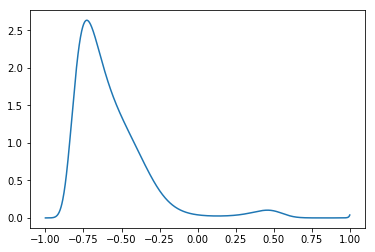

In [25]:
xs = np.linspace(-1,1,1000)
ys = f(xs)
plt.plot(xs, ys)

In [7]:
import cvxpy as cvx

In [26]:
class CvxEstimator:
    def __init__(
            self,
            a_min: float,
            a_max: float,
            moments,
            resolution=5000,
    ):
        self.k = len(moments)-1
        self.resolution = resolution

        self.min = a_min
        self.max = a_max
        # Bucket boundaries, n+1 boundaries for n buckets
        self.locs = np.concatenate([
            np.linspace(self.min, self.max, resolution),
            [self.max + (self.max-self.min)/resolution]
        ])

        self.data_moments = np.array(moments)
        # Moment values of the boundaries
        self.loc_moments = []
        for i in range(self.k+1):
            self.loc_moments.append(
                (self.locs)**i
            )
        self.loc_moments = np.array(self.loc_moments)

        # Rescale the inequalities to make tolerances more consistent
        scale_factor = self.data_moments.reshape(len(self.data_moments), 1)
        b = np.repeat(1, len(self.data_moments))

        Xs = cvx.Variable(resolution)
        self.Xs = Xs
        self.constraints = [
            Xs >= 0,
#             Xs[0] >= 1,
#             Xs[-1] >= 1,
            (self.loc_moments[:, :-1]/scale_factor) * Xs <= b,
            (self.loc_moments[:, 1:]/scale_factor) * Xs >= b
        ]

    def solve_gt(self, threshold: float):
        return self.solve_gt_l(threshold), self.solve_gt_u(threshold)

    def solve_gt_l(self, threshold: float):
        idx = np.searchsorted(self.locs, threshold)
        prob = cvx.Problem(
            cvx.Minimize(cvx.sum_entries(self.Xs[idx:])),
            self.constraints
        )
        return prob.solve(solver=cvx.ECOS, feastol=1e-8)

    def solve_gt_u(self, threshold: float):
        idx = np.searchsorted(self.locs, threshold)
        if idx == 0:
            idx = 1
        prob = cvx.Problem(
            cvx.Maximize(cvx.sum_entries(self.Xs[idx - 1:])),
            self.constraints
        )
        return prob.solve(solver=cvx.ECOS, feastol=1e-8)

    def solve_threshold_quantile(self, threshold):
        idx = np.searchsorted(self.locs, threshold)
        prob_l = cvx.Problem(
            cvx.Minimize(cvx.sum_entries(self.Xs[:idx-1])),
            self.constraints
        )
        lb = prob_l.solve(solver=cvx.GLPK)
        self.Xlb = self.Xs.value
        
        prob_r = cvx.Problem(
            cvx.Maximize(cvx.sum_entries(self.Xs[:idx])),
            self.constraints
        )
        ub = prob_r.solve(solver=cvx.GLPK)
        self.Xub = self.Xs.value
        
        count = self.data_moments[0]
        return lb/count, ub/count
    
    
    def solve_quantile_maxent(self, quantile):
        count = self.data_moments[0]
        prob = cvx.Problem(
            cvx.Maximize(cvx.sum_entries(cvx.entr(
                self.Xs / count
            ))),
            self.constraints
        )
        prob.solve(solver=cvx.ECOS, feastol=1e-7)

        values = self.Xs.value
        self.Xmaxent = values
        target_sum = count * quantile
        running_sum = 0
        excess_fraction = 0.5
        for i, val in enumerate(values):
            val = float(val)
            running_sum += val
            if running_sum >= target_sum:
                excess_fraction = (running_sum - target_sum) / val
                break

        best_est = (1-excess_fraction)*self.locs[i] + excess_fraction*self.locs[i+1]

        return best_est

In [27]:
k = 8
ms = [
    np.sum(data**i) for i in range(k)
]

In [28]:
est = CvxEstimator(
    np.min(data),
    np.max(data),
    ms
)

In [29]:
est.solve_quantile_maxent(.7)

51.021967979097006

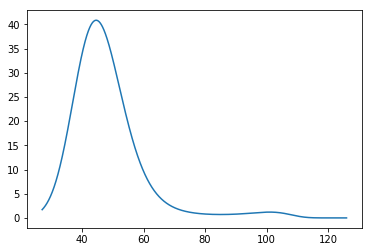

In [30]:
plt.plot(est.locs[:-1], est.Xmaxent)